In [1]:
!pip install datasets tokenizers scikit-learn matplotlib

In [2]:
# load english data
from datasets import load_dataset
import pandas as pd

def load_xnli_en():
    xnli_en = load_dataset("xnli", "en")
    def combine_text(example):
        return {
            "text": example["premise"] + " [SEP] " + example["hypothesis"],
            "label": example["label"]
        }
    en_data = xnli_en["train"].map(combine_text)
    return pd.DataFrame(en_data)[["text", "label"]]

df_en = load_xnli_en()

/Users/shuyuezhang/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 392702/392702 [00:10<00:00, 36372.79 examples/s]


In [14]:
# load Vietnamese data
def load_xnli_vi():
    xnli_vi = load_dataset("xnli", "vi")
    def combine_text(example):
        return {
            "text": example["premise"] + " [SEP] " + example["hypothesis"],
            "label": example["label"]
        }
    vi_data = xnli_vi["train"].map(combine_text)
    return pd.DataFrame(vi_data)[["text", "label"]]

df_vi = load_xnli_vi()

# BPE

In [3]:
# Train the BPE tokenizer function
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence as NormalizerSequence

def train_bpe_tokenizer(texts, vocab_size=10000, save_path="bpe_tokenizer_en.json"):
    with open("bpe_train.txt", "w", encoding="utf-8") as f:
        for line in texts:
            f.write(line + "\n")

    tokenizer = Tokenizer(BPE())
    tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
    tokenizer.train(["bpe_train.txt"], trainer)
    tokenizer.save(save_path)
    return tokenizer


In [4]:
# Word tokenization Text → Add the tokens_str column
def tokenize_with_method(df, tokenizer_obj, method_name):
    df_copy = df.copy()
    df_copy[f"tokens_str_{method_name}"] = df_copy["text"].apply(
        lambda x: " ".join(tokenizer_obj.encode(x).tokens)
    )
    return df_copy

In [5]:
# Draw the Zipf curve
from collections import Counter
import matplotlib.pyplot as plt

def plot_zipf(df_tokens, method_name):
    token_counts = Counter()
    for text in df_tokens:
        token_counts.update(text.split())

    sorted_tokens = token_counts.most_common()
    ranks = list(range(1, len(sorted_tokens) + 1))
    freqs = [freq for _, freq in sorted_tokens]

    plt.figure(figsize=(8, 5))
    plt.loglog(ranks, freqs)
    plt.title(f"Zipf Curve - {method_name}")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [6]:
# Construct the TF-IDF Logistic Regression classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def run_tfidf_lr(df, tokens_str_column):
    X_texts = df[tokens_str_column]
    y = df["label"]

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(X_texts)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"[{tokens_str_column}] Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred, digits=4))
    return acc


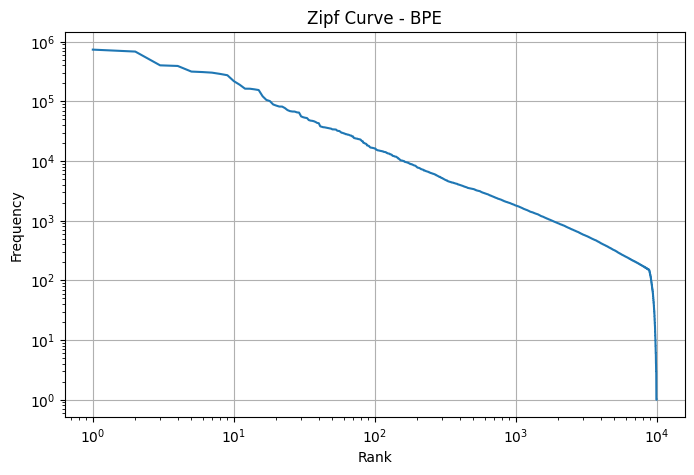

[tokens_str_bpe] Accuracy: 0.4415
              precision    recall  f1-score   support

           0     0.4283    0.4705    0.4484     26142
           1     0.4188    0.4119    0.4153     26314
           2     0.4819    0.4423    0.4613     26085

    accuracy                         0.4415     78541
   macro avg     0.4430    0.4416    0.4417     78541
weighted avg     0.4429    0.4415    0.4416     78541



0.4415146229357915

In [7]:
# english BPE
# Step 1: load data 
df_en = load_xnli_en()

# Step 2: Train the BPE tokenizer
bpe_tokenizer = train_bpe_tokenizer(df_en["text"], vocab_size=10000)

# Step 3: word tokenization
df_bpe = tokenize_with_method(df_en, bpe_tokenizer, "bpe")

# Step 4: Draw the Zipf curve
plot_zipf(df_bpe["tokens_str_bpe"], "BPE - English")

# Step 5: TF-IDF + Logistic Regression
run_tfidf_lr(df_bpe, "tokens_str_bpe")


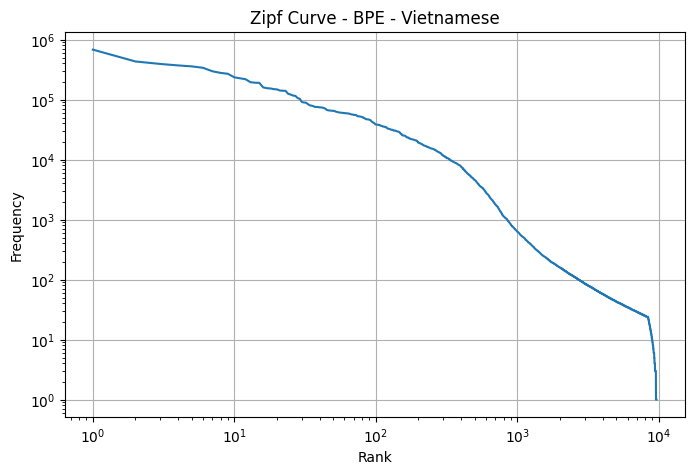

[tokens_str_bpe] Accuracy: 0.4222
              precision    recall  f1-score   support

           0     0.4190    0.4598    0.4384     26142
           1     0.4056    0.4005    0.4031     26314
           2     0.4442    0.4065    0.4245     26085

    accuracy                         0.4222     78541
   macro avg     0.4229    0.4223    0.4220     78541
weighted avg     0.4229    0.4222    0.4220     78541



0.4222380667422111

In [10]:
# Vietnamese BPE
bpe_tokenizer_vi = train_bpe_tokenizer(df_vi["text"], vocab_size=10000, save_path="bpe_tokenizer_vi.json")

df_vi_bpe = tokenize_with_method(df_vi, bpe_tokenizer_vi, "bpe")

plot_zipf(df_vi_bpe["tokens_str_bpe"], "BPE - Vietnamese")

run_tfidf_lr(df_vi_bpe, "tokens_str_bpe")


In [11]:
import random

def add_typo_noise(text, error_rate=0.05):
    """
    在文本中随机替换一定比例的字符，模拟 OCR 或拼写错误。
    只对英文字母生效。
    """
    chars = list(text)
    for i in range(len(chars)):
        if chars[i].isalpha() and random.random() < error_rate:
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)


In [12]:
# Add typo noise to english
df_en_noisy = df_en.copy()
df_en_noisy["text"] = df_en_noisy["text"].apply(lambda x: add_typo_noise(x, error_rate=0.05))

df_en_noisy_bpe = tokenize_with_method(df_en_noisy, bpe_tokenizer, "bpe_noisy")

print("After adding noise to English BPE model: ")
acc_noisy = run_tfidf_lr(df_en_noisy_bpe, "tokens_str_bpe_noisy")

original_acc = run_tfidf_lr(df_bpe, "tokens_str_bpe") 
drop = original_acc - acc_noisy
print(f"\n Accuracy of English BPE model reduces: {round(drop * 100, 2)}%")

After adding noise: 
[tokens_str_bpe_noisy] Accuracy: 0.4161
              precision    recall  f1-score   support

           0     0.3956    0.4179    0.4065     26142
           1     0.3987    0.3953    0.3970     26314
           2     0.4572    0.4353    0.4460     26085

    accuracy                         0.4161     78541
   macro avg     0.4172    0.4162    0.4165     78541
weighted avg     0.4171    0.4161    0.4164     78541

[tokens_str_bpe] Accuracy: 0.4415
              precision    recall  f1-score   support

           0     0.4283    0.4705    0.4484     26142
           1     0.4188    0.4119    0.4153     26314
           2     0.4819    0.4423    0.4613     26085

    accuracy                         0.4415     78541
   macro avg     0.4430    0.4416    0.4417     78541
weighted avg     0.4429    0.4415    0.4416     78541


 Accuracy reduces: 2.54%


In [13]:
# Add typo noise to 
df_vi_noisy = df_vi.copy()
df_vi_noisy["text"] = df_vi_noisy["text"].apply(lambda x: add_typo_noise(x, error_rate=0.05))

df_vi_noisy_bpe = tokenize_with_method(df_vi_noisy, bpe_tokenizer_vi, "bpe_noisy")

print("After adding noise to Vietnamese BPE model:")
acc_vi_noisy = run_tfidf_lr(df_vi_noisy_bpe, "tokens_str_bpe_noisy")

acc_vi_original = run_tfidf_lr(df_vi_bpe, "tokens_str_bpe")
drop_vi = acc_vi_original - acc_vi_noisy
print(f"\n Accuracy of Vietnamese BPE model reduces: {round(drop_vi * 100, 2)}%")

After adding noise to Vietnamese BPE model:
[tokens_str_bpe_noisy] Accuracy: 0.403
              precision    recall  f1-score   support

           0     0.3909    0.4111    0.4007     26142
           1     0.3903    0.3864    0.3883     26314
           2     0.4295    0.4117    0.4204     26085

    accuracy                         0.4030     78541
   macro avg     0.4036    0.4030    0.4032     78541
weighted avg     0.4035    0.4030    0.4031     78541

[tokens_str_bpe] Accuracy: 0.4222
              precision    recall  f1-score   support

           0     0.4190    0.4598    0.4384     26142
           1     0.4056    0.4005    0.4031     26314
           2     0.4442    0.4065    0.4245     26085

    accuracy                         0.4222     78541
   macro avg     0.4229    0.4223    0.4220     78541
weighted avg     0.4229    0.4222    0.4220     78541


 Accuracy of Vietnamese BPE model reduces: 1.92%


# WordPiece

In [15]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence as NormalizerSequence

def train_wordpiece_tokenizer(texts, vocab_size=10000, save_path="wordpiece_tokenizer.json"):
    with open("wp_train.txt", "w", encoding="utf-8") as f:
        for line in texts:
            f.write(line + "\n")

    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
    tokenizer.pre_tokenizer = Whitespace()

    trainer = WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
    )

    tokenizer.train(["wp_train.txt"], trainer)
    tokenizer.save(save_path)

    return tokenizer

In [ ]:
# Train the English WordPiece tokenizer
wordpiece_tokenizer_en = train_wordpiece_tokenizer(df_en["text"], save_path="wordpiece_tokenizer_en.json")

# Train the Vietnamese WordPiece tokenizer
wordpiece_tokenizer_vi = train_wordpiece_tokenizer(df_vi["text"], save_path="wordpiece_tokenizer_vi.json")

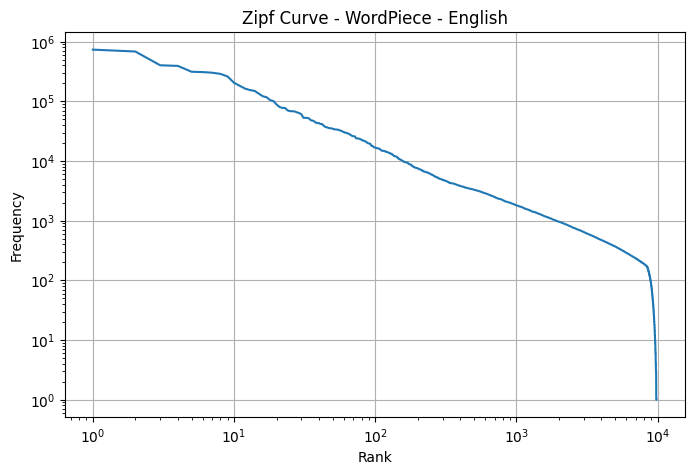

[tokens_str_wordpiece] Accuracy: 0.4435
              precision    recall  f1-score   support

           0     0.4334    0.4785    0.4549     26142
           1     0.4197    0.4097    0.4146     26314
           2     0.4809    0.4424    0.4609     26085

    accuracy                         0.4435     78541
   macro avg     0.4447    0.4435    0.4435     78541
weighted avg     0.4446    0.4435    0.4434     78541



In [17]:
# Load the WordPiece tokenizer
from tokenizers import Tokenizer
wordpiece_tokenizer_en = Tokenizer.from_file("wordpiece_tokenizer_en.json")

# Word tokenization generates tokens_str_wordpiece
df_wp_en = tokenize_with_method(df_en, wordpiece_tokenizer_en, "wordpiece")
plot_zipf(df_wp_en["tokens_str_wordpiece"], "WordPiece - English")

acc_wp_en = run_tfidf_lr(df_wp_en, "tokens_str_wordpiece")

In [18]:
# add noise
df_wp_en_noisy = df_en.copy()
df_wp_en_noisy["text"] = df_wp_en_noisy["text"].apply(lambda x: add_typo_noise(x, error_rate=0.05))

# Rework the new word tokenization using the WordPiece tokenizer for English
df_wp_en_noisy = tokenize_with_method(df_wp_en_noisy, wordpiece_tokenizer_en, "wordpiece_noisy")

acc_wp_en_noisy = run_tfidf_lr(df_wp_en_noisy, "tokens_str_wordpiece_noisy")
drop_wp_en = acc_wp_en - acc_wp_en_noisy

print(f"\n WordPiece (English) Accuracy Drop: {round(drop_wp_en * 100, 2)}%")

[tokens_str_wordpiece_noisy] Accuracy: 0.4143
              precision    recall  f1-score   support

           0     0.3939    0.4169    0.4051     26142
           1     0.3978    0.3910    0.3944     26314
           2     0.4539    0.4352    0.4444     26085

    accuracy                         0.4143     78541
   macro avg     0.4152    0.4144    0.4146     78541
weighted avg     0.4151    0.4143    0.4145     78541


📉 WordPiece (English) Accuracy Drop: 2.92%


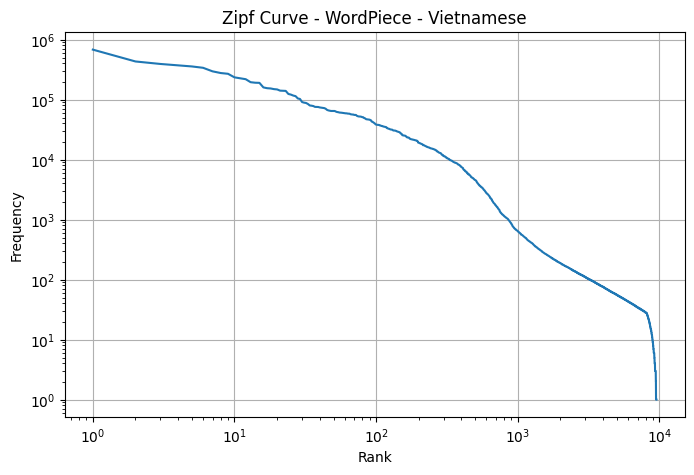

[tokens_str_wordpiece] Accuracy: 0.423
              precision    recall  f1-score   support

           0     0.4202    0.4612    0.4397     26142
           1     0.4084    0.4034    0.4059     26314
           2     0.4423    0.4045    0.4226     26085

    accuracy                         0.4230     78541
   macro avg     0.4236    0.4230    0.4227     78541
weighted avg     0.4236    0.4230    0.4227     78541



In [19]:
# Word tokenization generates tokens_str_wordpiece for Vietnamese
wordpiece_tokenizer_vi = train_wordpiece_tokenizer(df_vi["text"], save_path="wordpiece_tokenizer_vi.json")
df_wp_vi = tokenize_with_method(df_vi, wordpiece_tokenizer_vi, "wordpiece")
plot_zipf(df_wp_vi["tokens_str_wordpiece"], "WordPiece - Vietnamese")
acc_wp_vi = run_tfidf_lr(df_wp_vi, "tokens_str_wordpiece")

In [20]:
# Rework the new word tokenization using the WordPiece tokenizer for Vietnamese
df_wp_vi_noisy = df_vi.copy()
df_wp_vi_noisy["text"] = df_wp_vi_noisy["text"].apply(lambda x: add_typo_noise(x, error_rate=0.05))

df_wp_vi_noisy = tokenize_with_method(df_wp_vi_noisy, wordpiece_tokenizer_vi, "wordpiece_noisy")

acc_wp_vi_noisy = run_tfidf_lr(df_wp_vi_noisy, "tokens_str_wordpiece_noisy")

drop_wp_vi = acc_wp_vi - acc_wp_vi_noisy
print(f"\n WordPiece (Vietnamese) Accuracy Drop: {round(drop_wp_vi * 100, 2)}%")


[tokens_str_wordpiece_noisy] Accuracy: 0.4043
              precision    recall  f1-score   support

           0     0.3919    0.4128    0.4021     26142
           1     0.3929    0.3881    0.3905     26314
           2     0.4298    0.4120    0.4207     26085

    accuracy                         0.4043     78541
   macro avg     0.4048    0.4043    0.4044     78541
weighted avg     0.4048    0.4043    0.4044     78541


 WordPiece (Vietnamese) Accuracy Drop: 1.87%
